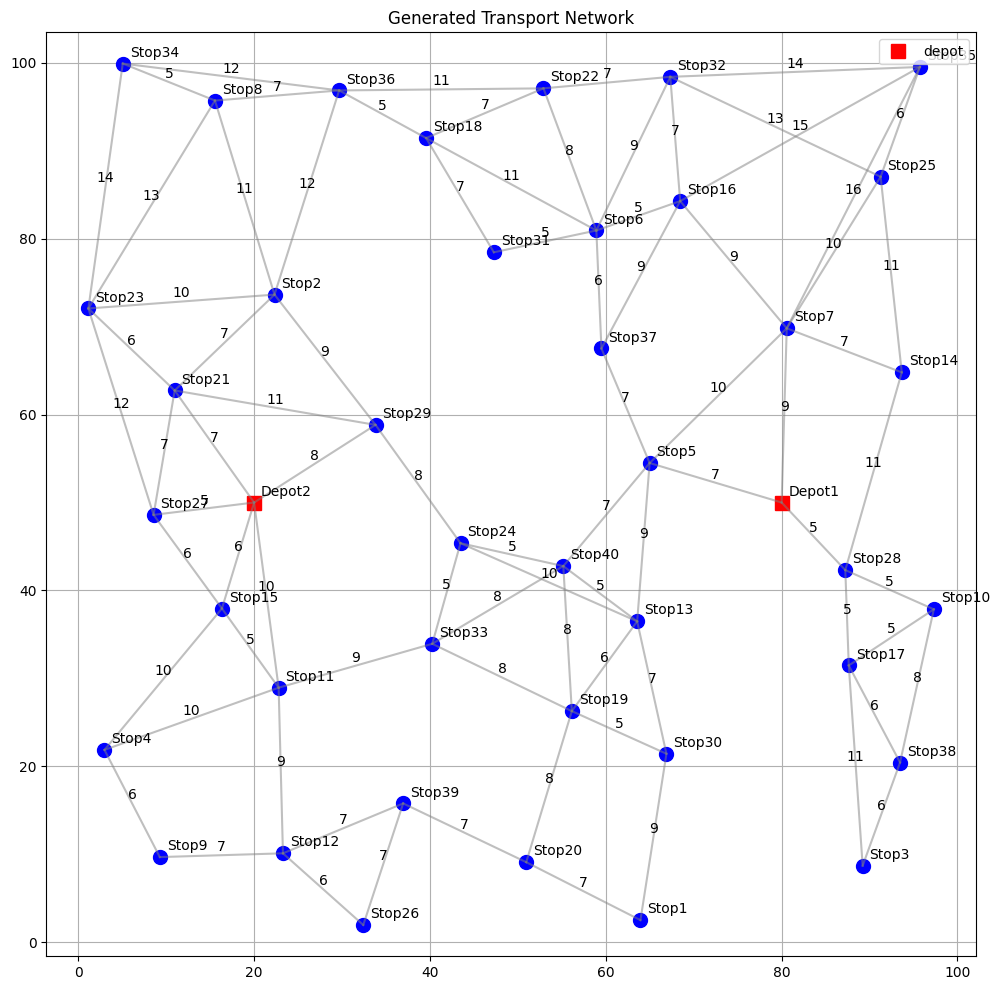

In [29]:
import data as dt

data_obj = dt.data()

graph, coords = data_obj.create_random_graph(n_stops=40, n_depots=2)
data_obj.visualize_graph(graph, coords)


In [28]:
import gurobipy as gb
import math
import data_inizialization as di

nv_rb_0 = {
    "r1" : {"M103": 3, "M104": 2},
    "r2" : {"M103": 2, "M104": 0},
    "r3" : {"M103": 1, "M104": 2},
    "r4" : {"M103": 1, "M104": 1},
}  # number of b-type *non-battery* buses on route r

lt_r = {
    "r1": 6,
    "r2": 18,
    "r3": 18,
    "r4": 4
}

ct_rjbc = { "r1":{  "Stop1":{"E433":{"c1":6}, "E420":{"c1":10}, "E302":{"c1":13}},
                    "Stop2":{"E433":{"c1":6}, "E420":{"c1":10}, "E302":{"c1":13}}},
            "r2":{  "Stop2":{"E433":{"c1":6}},
                    "Stop4":{"E433":{"c1":6}},
                    "Stop5":{"E433":{"c1":6}}},
            "r3":{  "Stop2":{"E420":{"c1":10}, "E302":{"c1":13}},
                    "Stop3":{"E420":{"c1":10}, "E302":{"c1":13}},
                    "Stop5":{"E420":{"c1":10}, "E302":{"c1":13}}},
            "r4":{  "Stop1":{"E433":{"c1":6}, "E420":{"c1":10}},
                    "Stop2":{"E433":{"c1":6}, "E420":{"c1":10}}}
            }


nob_rb = {
    "r1": {"E433": 0},
    "r2": {"E433": 1},
    "r3": {"E433": 2},
    "r4": {"E433": 2},
}  # number of *old b-type electric* buses on route r


V = ["M103", "M104"] # non battery vehicle type set
R = ["r1","r2","r3","r4"] # route set
B = ["E433", "E420", "E302"] #[E433, E420, E321, E490, 321D, 420D] # electric bus-type
D = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'depot'] # depot set
C = ["c1"]
B_rc = {
    "r1": {"c1": ["E433", "E420", "E302"]},
    "r2": {"c1": ["E433"]},
    "r3": {"c1": ["E420", "E302"]},
    "r4": {"c1": ["E433", "E420"]},                        # Also here we have one single charger type
} # type set of c-type charging electric buses of route r

distance_r = {"r1": [4, 4],
              "r2": [7, 4, 4, 7],
              "r3": [5, 3, 3, 5],
              "r4": [4, 4]} # distance of each stop in route r

B_r = {
    "r1": ["E433", "E420", "E302"],
    "r2": ["E433"],         
    "r3": ["E420", "E302"],
    "r4": ["E433", "E420"],
} # electric bus type set of route r

pi_r = {
    "r1": ["Stop1", "Stop2", "Stop1"],
    "r2": ["Stop4", "Stop5", "Stop2", "Stop5", "Stop4"],
    "r3": ["Stop5", "Stop3", "Stop2", "Stop3", "Stop5"],
    "r4": ["Stop2", "Stop1", "Stop2"]
} # route r cycle

C_b = {
    "E433": ["c1"],           # Since in base case we have C = [1] then each bus type supports the same single charging type
    "E420": ["c1"],
    "E302": ["c1"],
} # feasible charging type set for b-type electric buses

d_b_MAX = {"E433":15, "E420":25, "E302":20} # driving range of fully charged b_bus_types-type electric bus

# This is to generate S_rbc_s
S_rbc_s = {}
for r in R:
    stops = pi_r[r]
    stop_dists = distance_r[r]
    for b in B_r[r]:
        for c in C_b[b]:
            scenarios = di.generate_feasible_scenarios(r, stops, stop_dists, b, c, d_b_MAX[b])
            for idx, s in enumerate(scenarios, 1):
                S_rbc_s[(r, b, c, idx)] = list(s)

R_jc = di.compute_all_R_jc(S_rbc_s)

d_b_MAX = {"E433":15, "E420":25, "E302":20} # driving range of fully charged b_bus_types-type electric bus

capacities = [153, 87, 175, 130, 80] #starting from electric and then non battery vehicles

cap_b = {node: cap for node, cap in zip(B + V, capacities)}

dem_r = {}  # passenger demand of route r = past passenger capacity of all route r vehicles
            
# Calculate the passenger demand for each route
for r in set(nv_rb_0.keys()).union(nob_rb.keys()):
    dem = 0
    # Add capacities from non-battery buses
    for b, n in nv_rb_0.get(r, {}).items():
        dem += cap_b.get(b, 0) * n

    # Add capacities from old electric buses
    for b, n in nob_rb.get(r, {}).items():
        dem += cap_b.get(b, 0) * n

    dem_r[r] = dem

dem_0_r = {} # passenger capacity of route r to be satisfied by new electric buses and remaining non-battery vehicles
for r in R:
    dem_0_r[r] = dem_r[r] - sum(nob_rb[r].get(b, 0) * cap_b[b] for b in B_r[r])  ## calculating dem_0_r!
    # .get used because if we don't find a "bus" we just have 0 and not a crash (like with nob_rb[r][b])
    # no need of quicksum becuse we have only inputs and no variables

ub_rb = {
    # {1: {'busA': 3}},
} # upper bound on the number of new b-type electric buses
for r in R:
    ub_rb[r] = {}  # Initialize ub_rb for each route r
    for b in B_r[r]: # assuming B_r[r] gives buses relevant to route r            ## calculating ub_rb
        numerator = dem_0_r[r]
        denominator = cap_b[b]
        ub_rb[r][b] = math.ceil(numerator/denominator)



nc_jrc_max = {}  # number of c-type plug devices at stop j, route r, charger type c

for j in N:
    if j not in D:
        print(f"Processing stop: {j}")
        for c in C:
            for r in R_jc[j,c]:
                
                # Initialize nested dictionaries if not present
                if j not in nc_jrc_max:
                    nc_jrc_max[j] = {}
                if r not in nc_jrc_max[j]:
                    nc_jrc_max[j][r] = {}
                
                x =  di.compute_nc_jrc_max(r,j,c, B_rc[r][c], ct_rjbc, lt_r[r]) # This will compute the maximum number of plug devices at stop j, route r, charger type c
                nc_jrc_max[j][r][c] = x
print(nc_jrc_max)

Processing stop: Stop1
Processing stop: Stop2
Processing stop: Stop3
Processing stop: Stop4
Processing stop: Stop5
{'Stop1': {'r1': {'c1': 0}, 'r4': {'c1': 0}}, 'Stop2': {'r1': {'c1': 0}, 'r4': {'c1': 0}, 'r3': {'c1': 0}, 'r2': {'c1': 0}}, 'Stop3': {'r3': {'c1': 0}}, 'Stop4': {'r2': {'c1': 0}}, 'Stop5': {'r3': {'c1': 0}, 'r2': {'c1': 0}}}


In [6]:
import data_inizialization as di
import numpy as np

R = ["r1","r2","r3","r4"] # route set
B = ["E433", "E420", "E302"] #[E433, E420, E321, E490, 321D, 420D] # electric bus-type
C = ["c1"] # charging type set   # In the base case |C| = 1 -> c = 1 -> we just have one charging type -> In the random cases, so modified base cases -> we several c types

n_rbc_data_2d = np.array([
    [1, 1, 1, 1],  # E433
    [2, 1, 1, 2],  # E420
    [2, 2, 2, 2],  # E302
])

pi_r = {
    "r1": ["stop1", "stop2", "stop1"],
    "r2": ["stop4", "stop5", "stop2", "stop5", "stop4"],
    "r3": ["stop5", "stop3", "stop2", "stop3", "stop5"],
    "r4": ["stop2", "stop1", "stop2"]
} # route r cycle

d_b_MAX = {"E433":15, "E420":25, "E302":20} # driving range of fully charged b_bus_types-type electric bus

B_r = {
    "r1": ["E433", "E420", "E302"],
    "r2": ["E433"],         
    "r3": ["E420", "E302"],
    "r4": ["E433", "E420"],
} # electric bus type set of route r

C_b = {
    "E433": "c1",           # Since in base case we have C = [1] then each bus type supports the same single charging type
    "E420": "c1",
    "E302": "c1",
} # feasible charging type set for b-type electric buses

distance_r = {"r1": [4, 4],
              "r2": [7, 4, 4, 7],
              "r3": [5, 3, 3, 5],
              "r4": [4, 4]} # distance of each stop in route r

# This is to generate S_rbc_s
S_rbc_s = {}
for r in R:
    stops = pi_r[r]
    stop_dists = distance_r[r]
    for b in B_r[r]:
        for c in C_b[b]:
            scenarios = di.generate_feasible_scenarios(r, stops, stop_dists, b, c, d_b_MAX[b])
            for idx, s in enumerate(scenarios, 1):
                S_rbc_s[(r, b, c, idx)] = list(s)


# Define R_jc
R_jc = di.compute_all_R_jc(S_rbc_s)
print("R_jc:", R_jc)

R_jc: {('stop1', 'c'): {'r1', 'r4'}, ('stop2', 'c'): {'r1', 'r4', 'r3', 'r2'}, ('stop1', '1'): {'r1', 'r4'}, ('stop2', '1'): {'r1', 'r4', 'r3', 'r2'}, ('stop4', 'c'): {'r2'}, ('stop5', 'c'): {'r3', 'r2'}, ('stop4', '1'): {'r2'}, ('stop5', '1'): {'r3', 'r2'}, ('stop3', 'c'): {'r3'}, ('stop3', '1'): {'r3'}}


In [ ]:
import data_inizialization as di
import numpy as np
import importlib

importlib.reload(di)

R = ["r1","r2","r3","r4"] # route set
B = ["E433", "E420", "E302"] #[E433, E420, E321, E490, 321D, 420D] # electric bus-type
C = ["c1"] # charging type set   # In the base case |C| = 1 -> c = 1 -> we just have one charging type -> In the random cases, so modified base cases -> we several c types

n_rbc_data_2d = np.array([
    [1, 1, 1, 1],  # E433
    [2, 1, 0, 2],  # E420
    [2, 2, 2, 2],  # E302
])

n_rbc_data = n_rbc_data_2d[:, :, np.newaxis].transpose(1, 0, 2) #just this case since we need also a c dimensione even if it is just 1

n_rbc = di.init_n_rbc(n_rbc_data, R, B, C) # Initialize n_rbc with data from data_inizialization module

print(n_rbc)

{('r1', 'E433', 'c1'): 1, ('r1', 'E420', 'c1'): 2, ('r1', 'E302', 'c1'): 2, ('r2', 'E433', 'c1'): 1, ('r2', 'E420', 'c1'): 1, ('r2', 'E302', 'c1'): 2, ('r3', 'E433', 'c1'): 1, ('r3', 'E420', 'c1'): 0, ('r3', 'E302', 'c1'): 2, ('r4', 'E433', 'c1'): 1, ('r4', 'E420', 'c1'): 2, ('r4', 'E302', 'c1'): 2}


In [10]:


TO_j = {
            stop: [stop] for stop in N if G.nodes[stop].get("charging_possible", True)
        }

print(TO_j)

{'Depot1': ['Depot1'], 'Stop3': ['Stop3']}
